# 17기 Clustering 정규세션 과제

## Clustering 해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. Clustering 
수업 내용 및 실습 자료를 참고하여 클러스터링을 자유롭게 진행해주세요. 한 알고리즘에 대해 파라미터를 바꿔가며 비교를 해도 되고, 여러 알고리즘의 결과를 비교해도 됩니다.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

## 0. 데이터 불러오기

In [40]:
import pandas as pd
raw = pd.read_csv("Mall_Customers.csv", index_col = 0)
raw.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


# 1. Preprocessing and EDA

In [41]:
raw.shape

(200, 4)

In [42]:
raw.info()
data = raw.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


결측치는 존재하지 않는것을 알 수 있습니다.  

In [43]:
# 기초 통계량을 구해 줍니다.
data.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


기초통계량을 보면 scaling일 필요함을 알 수 있습니다.  
Gender 변수를 제외하고 scaling을 해줍니다.


In [44]:

from sklearn.preprocessing import StandardScaler
import numpy as np


gender = pd.DataFrame(np.array(raw.Gender), columns=["Gender"])
standard_scaler = StandardScaler()
data_scaled = pd.DataFrame(standard_scaler.fit_transform(data[['Age',"Annual Income (k$)","Spending Score (1-100)"]]), 
                    columns = ['Age',"Annual Income (k$)","Spending Score (1-100)"])


# 따로 남겨두었던 gender를 다시 추가해 줍니다.
data_scaled['Gender'] = gender
data_scaled

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,Male
1,-1.281035,-1.738999,1.195704,Male
2,-1.352802,-1.700830,-1.715913,Female
3,-1.137502,-1.700830,1.040418,Female
4,-0.563369,-1.662660,-0.395980,Female
...,...,...,...,...
195,-0.276302,2.268791,1.118061,Female
196,0.441365,2.497807,-0.861839,Female
197,-0.491602,2.497807,0.923953,Male
198,-0.491602,2.917671,-1.250054,Male


In [45]:
# Cataegorical variable은 Gender를 one-hot encoding 해줍니다.

data['Female'] = pd.get_dummies(data.Gender).Female
data['Male'] = pd.get_dummies(data.Gender).Male

data_scaled['Female'] = pd.get_dummies(data_scaled.Gender).Female
data_scaled['Male'] = pd.get_dummies(data_scaled.Gender).Male


In [46]:
# scaling하기전의 data입니다.
data.head(3)

,Gender,Age,Annual Income (k$),Spending Score (1-100),Female,Male
CustomerID,,,,,,
1,Male,19,15,39,0,1
2,Male,21,15,81,0,1
3,Female,20,16,6,1,0


In [47]:
# scaling하고난후의 data입니다.
data_scaled.head(3)

,Age,Annual Income (k$),Spending Score (1-100),Gender,Female,Male
0,-1.424569,-1.738999,-0.434801,Male,0,1
1,-1.281035,-1.738999,1.195704,Male,0,1
2,-1.352802,-1.700830,-1.715913,Female,1,0


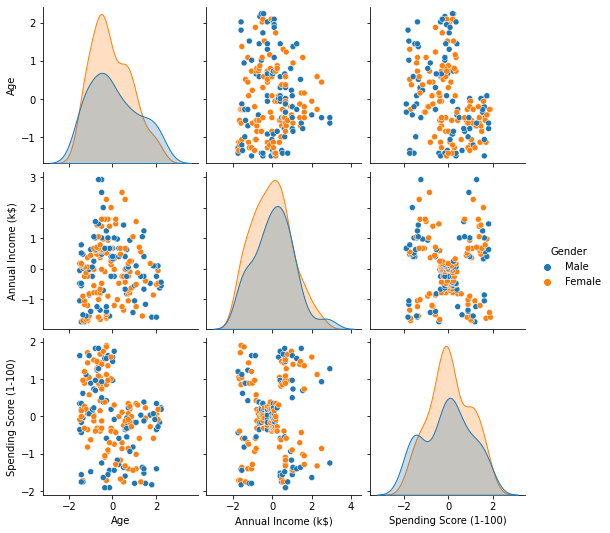

In [48]:
# Gender 변수를 이용하여 pairplot을 그려 봅니다.
import seaborn as sns

fig = sns.pairplot(data_scaled.drop(["Female","Male"],axis = 1), hue = "Gender")

그려본 결과 Annual Income변수와 Spending Score변수는 확실하게 5개의 group으로 나눌 수 있어 보입니다.  
또한 남자와 여자의 차이가 거의 없으므로 군집을 나눌때 남자와 여자는 나뉘면 안됩니다. 


In [49]:
# 마지막으로 Gender 변수는 필요 없으므로 삭제해 줍니다.
data.drop(('Gender'), axis = 1, inplace = True)
data_scaled.drop(('Gender'), axis = 1, inplace = True)

# 2. Clustering
### 2.1 Hierarchical Clustering
scale하기전의 데이터와 scale한 후의 데이터 모두 진행합니다.

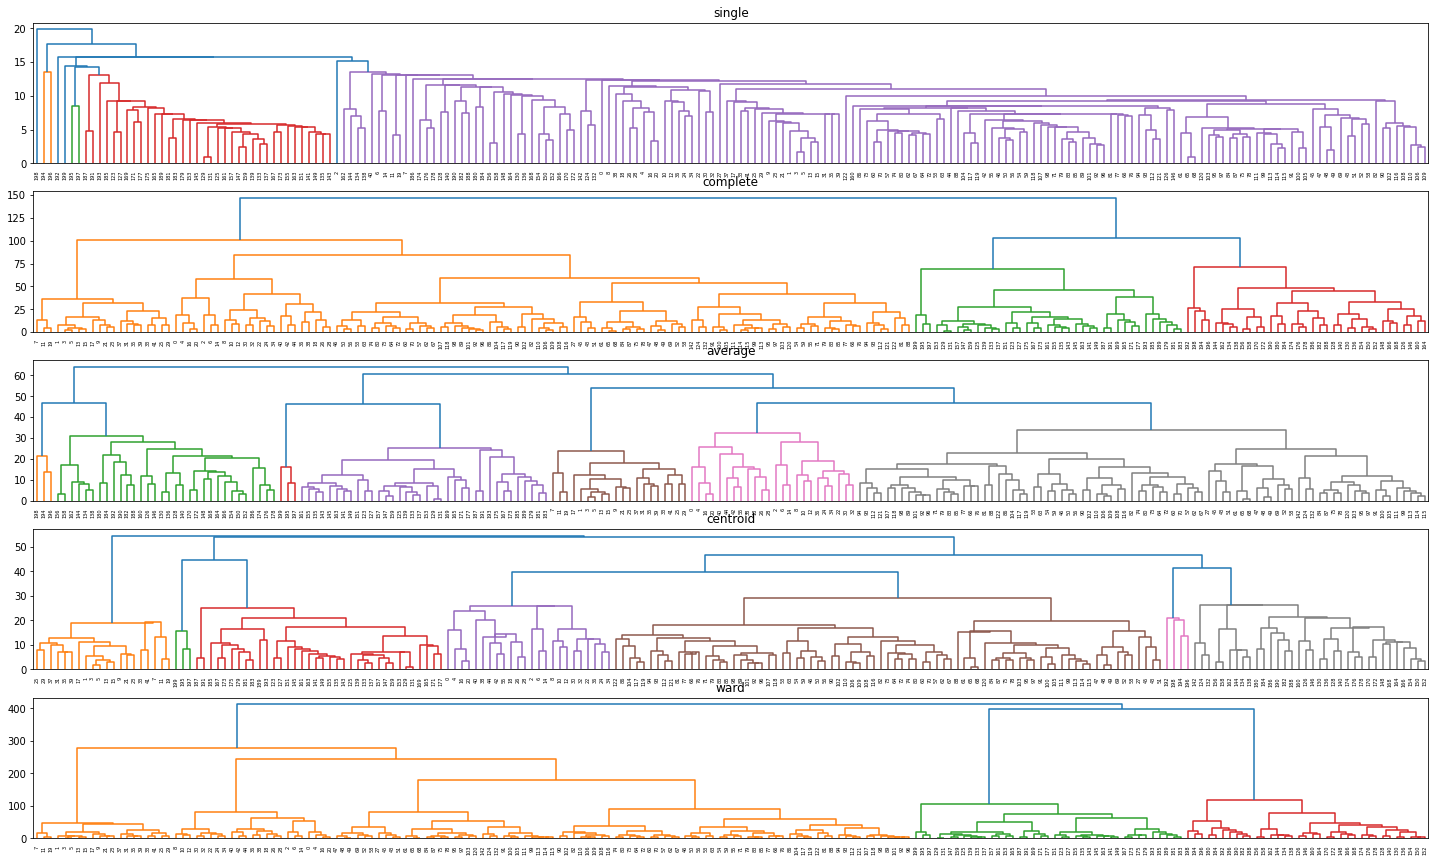

In [50]:
import matplotlib.pylab as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# 순서대로 min / max / ave / center / ward's 입니다.
linkage_list = ['single', 'complete', 'average', 'centroid', 'ward']

# Scale하기 전의 data입니다.
# Dendrogram을 그려주는 함수를 정의 합니다. 
def den(data , linkage_list):
    fig, axes = plt.subplots (nrows = len(data.columns), ncols = 1, figsize=(25,15)) # plt를 정의해 줍니다.
    
    for i in range(len(linkage_list)):                               # 방법을 iterate합니다.
        hierarchical_single = linkage(data, method=linkage_list[i])  # iterate되는 방법으로 Hierarchical Clustering을 실행합니다.
        dn = dendrogram(hierarchical_single, ax = axes[i])           # 각 순번에 맞게 dendrogram을 정의해 줍니다.
        axes[i].title.set_text(linkage_list[i])                      # 각 순번에 맞게 text를 정의해 줍니다.
    plt.show()                                                       # 그립니다.
    
den(data = data , linkage_list = linkage_list)

In [51]:
# 위 결과를 보면 ave방법이 가장 잘되었음을 알 수 있습니다.
# 이제 이를 시각화 해봅니다.

from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='average') # 5개로 고정 / ave 방법을 사용합니다.
labels = agg_clustering.fit_predict(data)                                 # 결과를 저장합니다. 이는 군집 번호라고 생각하면 됩니다. 

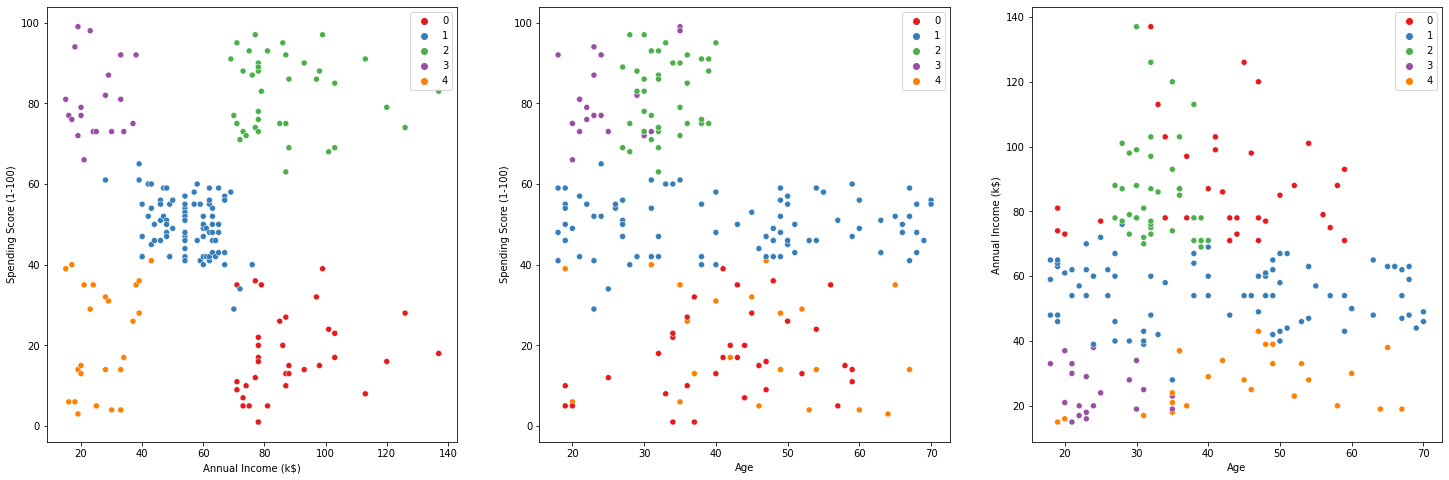

In [52]:
# 예측값을 그려주는 함수를 정의 합니다.

def pred(data, labels):
    fig, axes = plt.subplots (nrows = 1, ncols = 3, figsize=(25,8)) # plt를 정의해 줍니다.
    
    for i,j in enumerate((['Annual Income (k$)','Spending Score (1-100)'],['Age', 'Spending Score (1-100)'],['Age', 'Annual Income (k$)'])):                                       
        sns.scatterplot(x=j[0], y=j[1], data=data, hue=labels, palette='Set1', ax = axes[i])
    plt.show()        

pred(data = data, labels = labels)


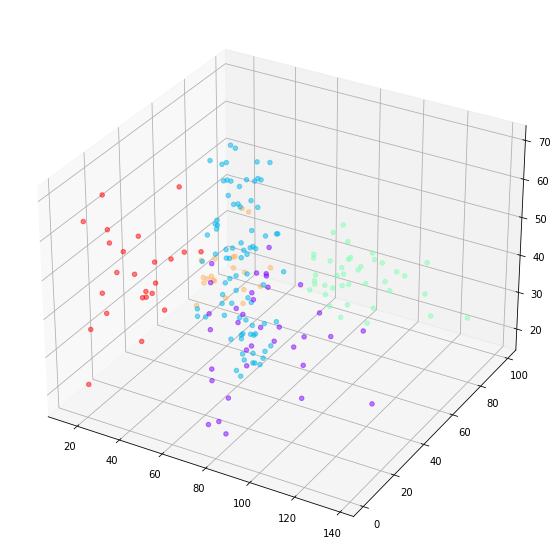

In [53]:
# 3차원에 나타냅니다.

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = data['Annual Income (k$)']
y = data['Spending Score (1-100)']
z = data['Age']
ax.scatter(x, y, z, c = labels, s= 20, alpha=0.5, cmap='rainbow')

In [54]:
# evaluation
from sklearn.metrics import silhouette_score

silhouette_score(data_scaled, agg_clustering.labels_ )

0.2595830356501951

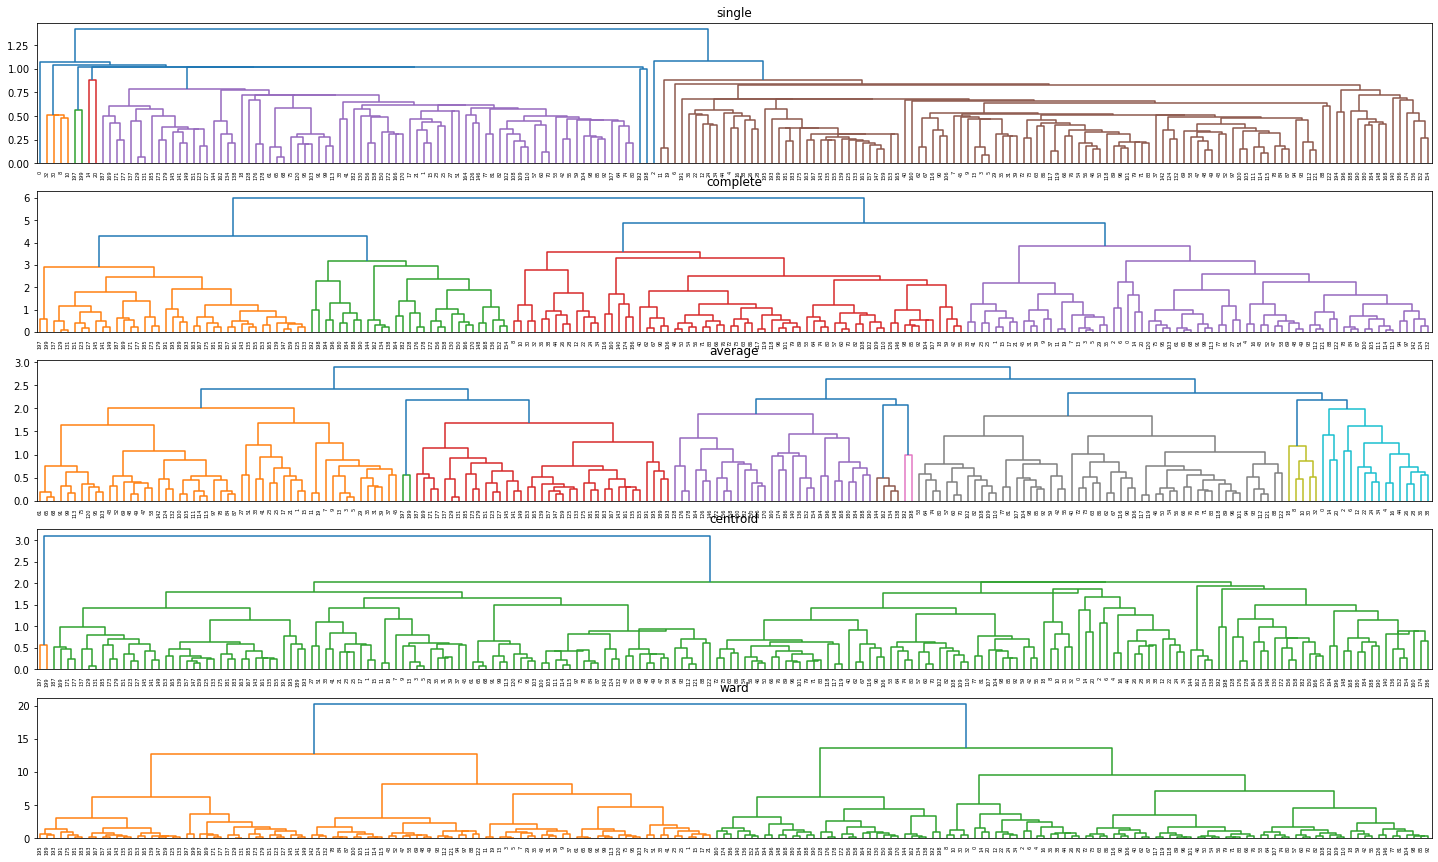

In [55]:
# scaled data입니다.
den(data = data_scaled , linkage_list = linkage_list)

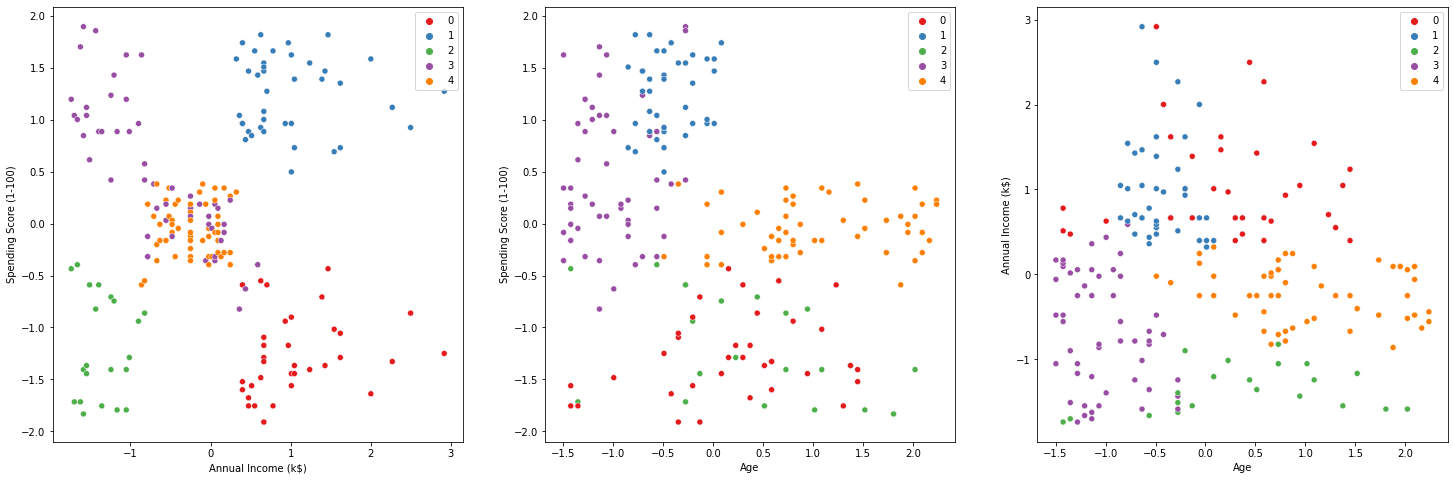

In [56]:
# scaled data입니다.
agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='average')
labels = agg_clustering.fit_predict(data_scaled)

pred(data = data_scaled, labels = labels)

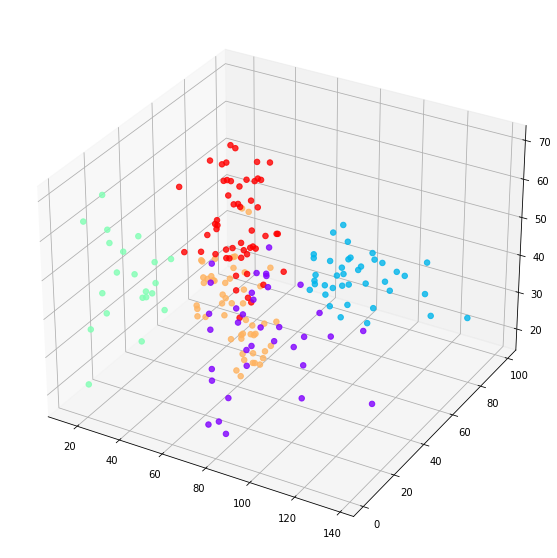

In [57]:
# scaled data입니다.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = data['Annual Income (k$)']
y = data['Spending Score (1-100)']
z = data['Age']
ax.scatter(x, y, z, c = labels, s= 30, alpha=0.8, cmap='rainbow')

In [58]:
# evaluation
silhouette_score(data_scaled, agg_clustering.labels_ )

0.31740251470750075

### 2.2 K-Means

Text(0.5, 1.0, 'Elbow plot (scaled data)')

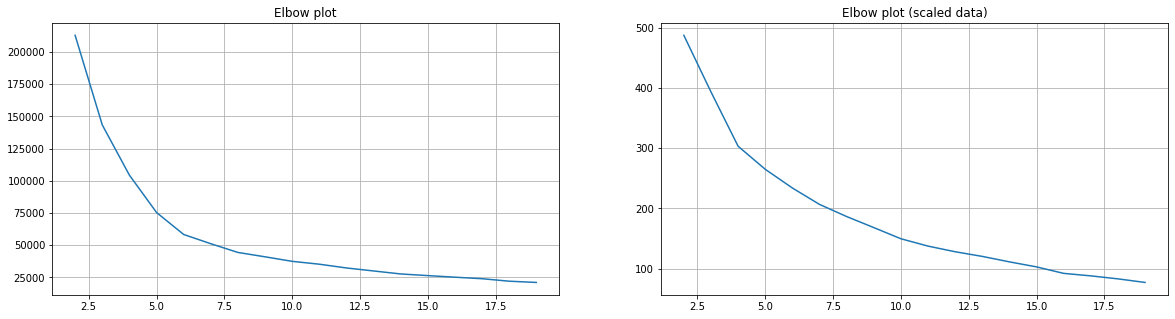

In [59]:
from sklearn.cluster import KMeans

# Elbow plot

fig = plt.figure( figsize = (20, 5) )

list_  = []
for k in range(2, 20):
    kmeans = KMeans( n_clusters = k )
    kmeans.fit( data )
    list_ .append( kmeans.inertia_ )


plt.subplot(1, 2, 1)               
plt.plot(range(2, 20), list_ , )
plt.grid(True)
plt.title('Elbow plot')

list_  = []
for k in range(2, 20):
    kmeans = KMeans( n_clusters = k )
    kmeans.fit( data_scaled )
    list_ .append( kmeans.inertia_ )

plt.subplot(1, 2, 2)               
plt.plot(range(2, 20), list_ )
plt.grid(True)
plt.title('Elbow plot (scaled data)')



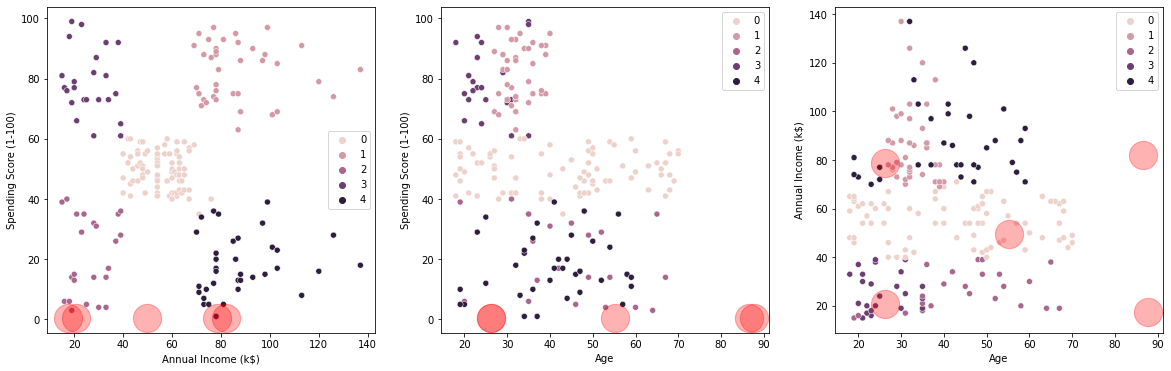

In [60]:
# scale되기 전의 data입니다.
# k=5 일때 를 기준으로 합니다.
# 빨간색으로 중심을 표현합니다.

kmeans = KMeans(n_clusters=5)
kmeans.fit(data)


plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)       
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=data, hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], c='red', alpha=0.3, s=800)

plt.subplot(1, 3, 2)    
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=data, hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 3], c='red', alpha=0.3, s=800)

plt.subplot(1, 3, 3)    
sns.scatterplot(x='Age', y='Annual Income (k$)', data=data, hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red', alpha=0.3, s=800)

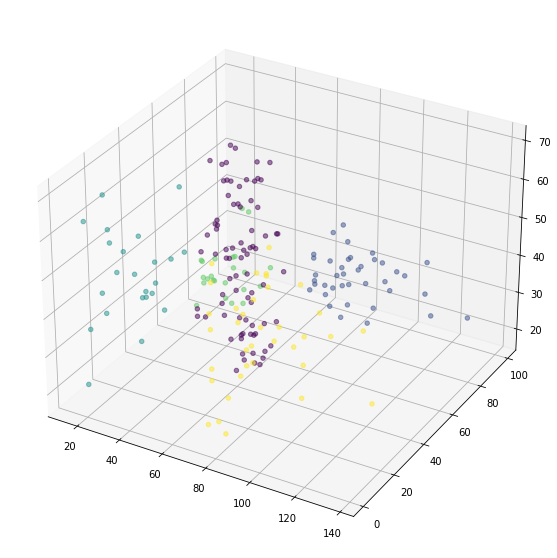

In [61]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = data['Annual Income (k$)']
y = data['Spending Score (1-100)']
z = data['Age']
ax.scatter(x, y, z, c = kmeans.labels_, s= 20, alpha=0.5)

In [62]:
# evaluation

silhouette_score(data, kmeans.labels_ )


0.443849645338732

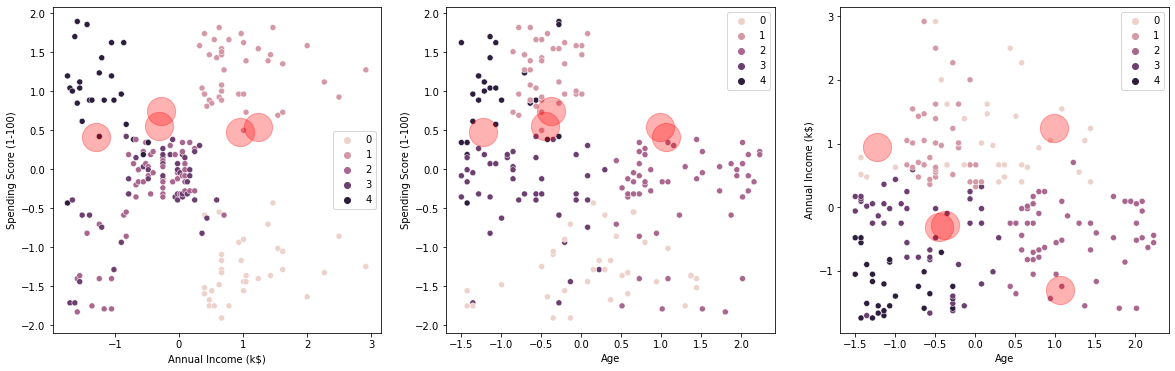

In [63]:
# scale된 data입니다.
# k=5 일때 를 기준으로 합니다.
# 빨간색으로 중심을 표현합니다.
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_scaled)

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)   
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=data_scaled, hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], c='red',alpha=0.3, s=800)

plt.subplot(1, 3, 2)   
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=data_scaled, hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 3], c='red',alpha=0.3, s=800)

plt.subplot(1, 3, 3)   
sns.scatterplot(x='Age', y='Annual Income (k$)', data=data_scaled, hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red',alpha=0.3, s=800)

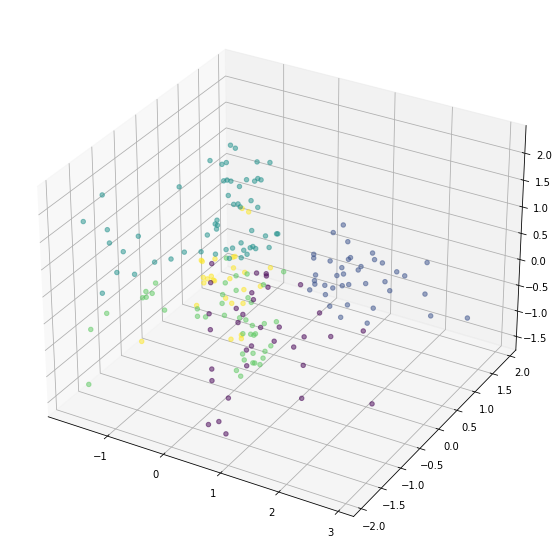

In [64]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = data_scaled['Annual Income (k$)']
y = data_scaled['Spending Score (1-100)']
z = data_scaled['Age']
ax.scatter(x, y, z, c = kmeans.labels_, s= 20, alpha=0.5)

In [65]:
# evaluation

silhouette_score(data_scaled, kmeans.labels_ )

0.3074066082399932

### 2.3 DBSCAN

**모수결정**  
<img src="https://t1.daumcdn.net/cfile/tistory/99EEF4475FEF3B5F31"  style="width: 700px; height: auto;"> 


eps is 18.2208671582886


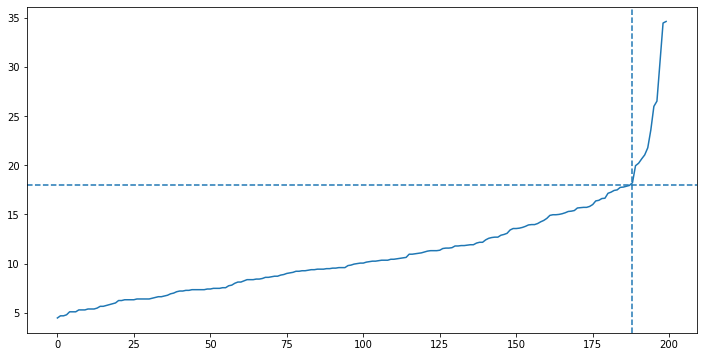

In [66]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# scale 되지 않은 데이터에 대한 모수 결정 입니다.

neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(data)
distances, indices = neigh.kneighbors(data) 


plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))
plt.axvline(188, 0, 2, ls='--')
plt.axhline(18, 0, 200, ls='--')
print("eps is",np.sort(distances[:, 4])[188])





[-1  0]


<AxesSubplot:xlabel='Age', ylabel='Annual Income (k$)'>

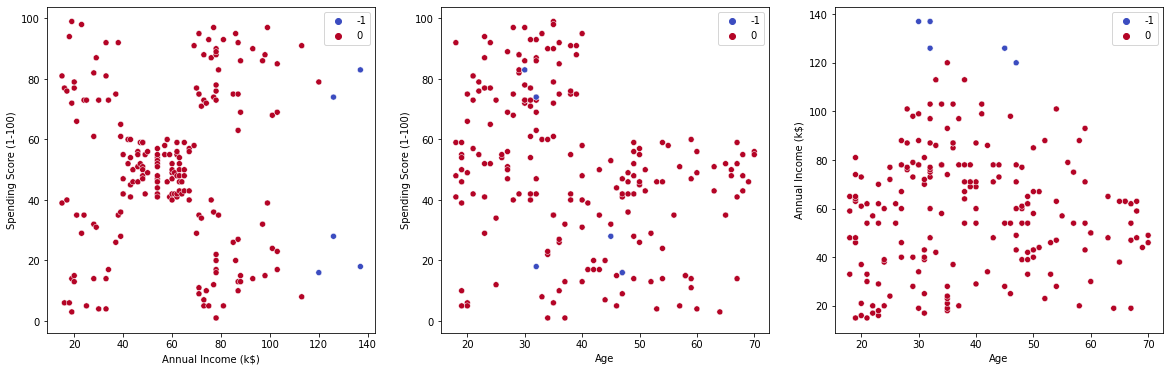

In [67]:
dbscan = DBSCAN(eps=18, min_samples=4) # scaling 하지 않은 데이터로 DBSCAN 학습
dbscan.fit(data)

print(np.unique(dbscan.labels_))

plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=data, hue=dbscan.labels_, palette='coolwarm')
plt.subplot(132)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=data, hue=dbscan.labels_, palette='coolwarm')
plt.subplot(133)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=data, hue=dbscan.labels_, palette='coolwarm')

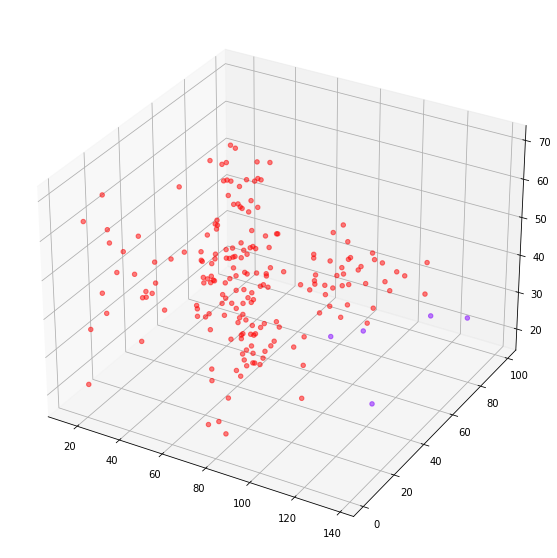

In [68]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = data['Annual Income (k$)']
y = data['Spending Score (1-100)']
z = data['Age']
ax.scatter(x, y, z, c = dbscan.labels_, s= 20, alpha=0.5, cmap='rainbow')

In [69]:
# evaluation

silhouette_score(data, dbscan.labels_ )

0.3729779743965328

1.0792036945604633


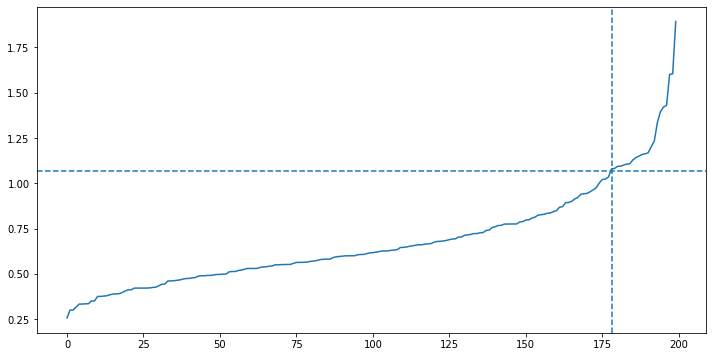

In [70]:
# scale된 데이터에 대한 모수 결정 입니다.

neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(data_scaled)
distances, indices = neigh.kneighbors(data_scaled)

plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))
plt.axvline(178, 0, 2, ls='--')
plt.axhline(1.07, 0, 200, ls='--')
print("eps is", np.sort(distances[:, 4])[178] )

[-1  0  1]


<AxesSubplot:xlabel='Age', ylabel='Annual Income (k$)'>

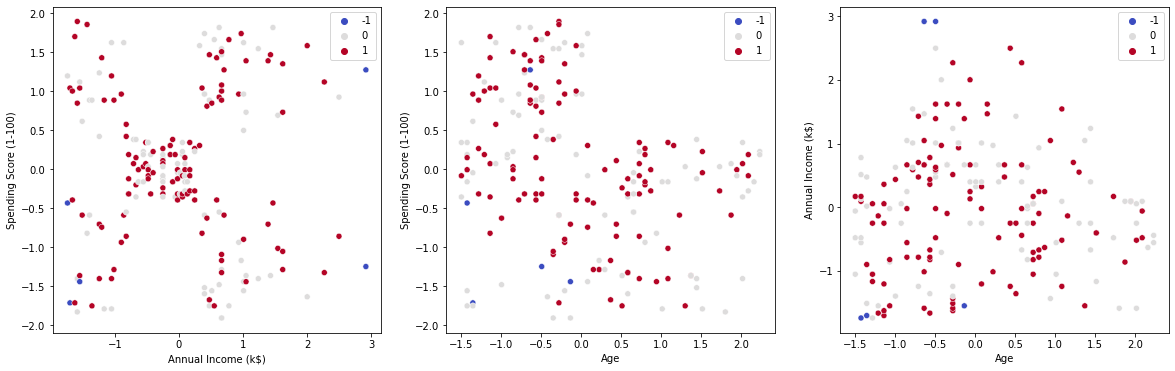

In [71]:
dbscan = DBSCAN(eps=1.07, min_samples=4) # 위에서 구한 eps와 minpts로 scaling된 데이터 DBSCAN 학습
dbscan.fit(data_scaled)
print(np.unique(dbscan.labels_))

plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=data_scaled, hue=dbscan.labels_, palette='coolwarm')
plt.subplot(132)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=data_scaled, hue=dbscan.labels_, palette='coolwarm')
plt.subplot(133)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=data_scaled, hue=dbscan.labels_, palette='coolwarm')


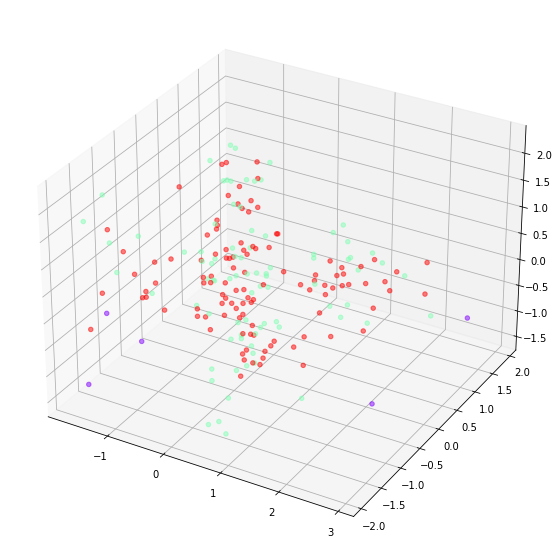

In [72]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = data_scaled['Annual Income (k$)']
y = data_scaled['Spending Score (1-100)']
z = data_scaled['Age']
ax.scatter(x, y, z, c = dbscan.labels_, s= 20, alpha=0.5, cmap='rainbow')

In [73]:
# evaluation

silhouette_score(data_scaled, dbscan.labels_ )

0.17135976501878936

확실히 scaled data의 silhouette score가 더 좋습니다.